Object Detection
installation instructions - https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md
object detection tutorial - https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import skimage.io as io

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

Env setup

In [2]:
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/home/malysheva/DL/models/research/")
sys.path.append("/home/malysheva/DL/models/research/object_detection")


Object detection imports

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

Model preparation
- Variables

In [4]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('/home/malysheva/DL/models/research/object_detection/data/pascal_label_map.pbtxt')

NUM_CLASSES = 20

- Download Model

In [5]:
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

- Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

- Loading label map

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

- Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

Detection

In [11]:
PATH_TO_TEST_IMAGES_DIR = '/home/malysheva/DL/models/research/VOCdevkit/VOC2012/JPEGImages'

trains=[]
with open('/home/malysheva/DL/models/research/VOCdevkit/VOC2012/ImageSets/Main/train.txt') as f:
    trains = f.read().splitlines()
val=[]
with open('/home/malysheva/DL/models/research/VOCdevkit/VOC2012/ImageSets/Main/val.txt') as f:
    val = f.read().splitlines()
    
#val.txt to long, so I take last 5.
TRAIN_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, trains[i] + ".jpg") for i in range(len(trains)) ]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, val[i] + ".jpg") for i in range(len(tests))][-5:]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

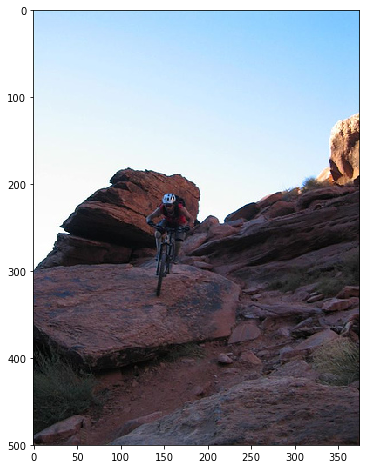

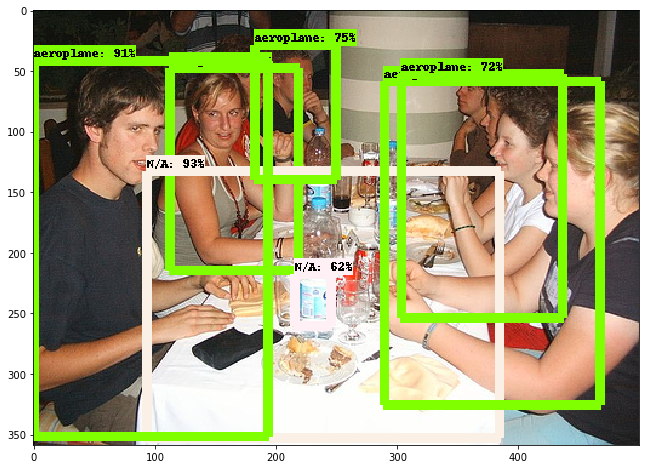

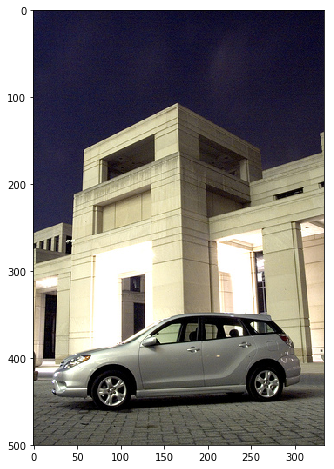

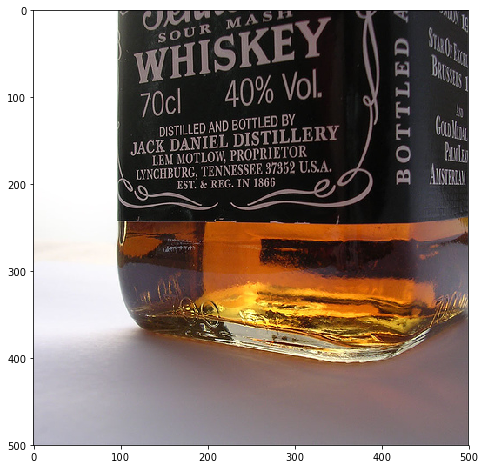

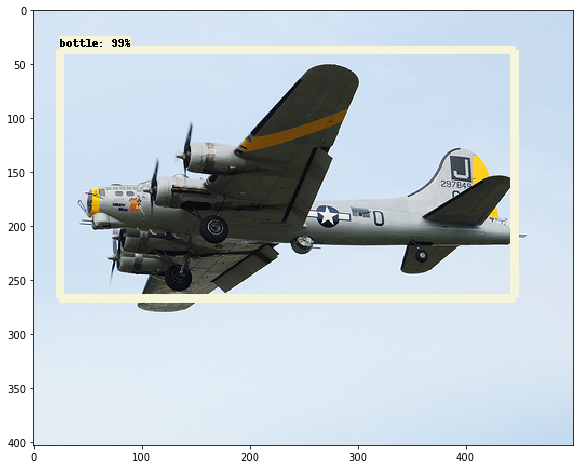

In [12]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)